<a href="https://colab.research.google.com/github/pavi-ninjaac/specrom_newsAPI/blob/main/Politics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [138]:
! pip3 install algorithmia

     |████████████████████████████████| 122kB 6.4MB/s 


In [ ]:
! pip3 install wordcloud

In [139]:
# import the nedded libraries
import numpy as np
import pandas as pd

import Algorithmia
import wordcloud

In [2]:
def getData():
    input = {
  "domains": "cnn.com",
  "topic": "politics",
  "q": "",
  "qInTitle": "",
  "content": "false",
  "page": "1",
  "author_only": "True"
    }
    client = Algorithmia.client('simQ9w1MCYmLaZgMqH9r9GoEoXe1')
    algo = client.algo('specrom/LatestNewsAPI/0.1.6')
    algo.set_options(timeout=300) 
    result = algo.pipe(input).result
    
    col_names=['author','description','publishedAt','source_name','source_url','title','url','urlToImage']
    data=[]
    
    for i in result["Article"]:
      data.append(np.array([i[str(x)] for x in col_names]))
    
    df = pd.DataFrame(data=data,columns=col_names)
    
    df.to_csv('F:\spectromNewsAPI\politics_data.csv')
    print("converted sunccesfully!!!!!!!!!!!!!!!")
    

In [12]:
#load file from local system
from google.colab import files
uploaded = files.upload()


Saving politics_full_data.csv to politics_full_data (2).csv


In [14]:
import io
df = pd.read_csv(io.BytesIO(uploaded['politics_full_data.csv']),index_col=0)

#shape of the dataframe
print('The shape of the dataframe is :',df.shape)


The shape of the dataframe is : (181, 8)


In [36]:
# Extract the data, which we need only the describtion column
data = df.iloc[:,[0,1,2]]
data.head(5)

,author,description,publishedAt
0,[],"Gabriel Sterling, the voting systems implement...",03-12-2020
1,[],President Trump and his allies are repeatedly ...,03-12-2020
2,"[""Amir Vera and Andy Rose, CNN""]",Heavy rains and flooding washed out a hillside...,03-12-2020
3,[],"Gabriel Sterling, the voting systems implement...",03-12-2020
4,"[""Jim Acosta and Devan Cole, CNN""]",President Donald Trump is frustrated with Atto...,03-12-2020


In [42]:
# changing the author column to spefic author name only

author = [data['author'][index][2:-7] for index in range(0,181)]
data['author'] = pd.Series(author)
data.head(5)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,author,description,publishedAt
0,,"Gabriel Sterling, the voting systems implement...",03-12-2020
1,,President Trump and his allies are repeatedly ...,03-12-2020
2,Amir Vera and Andy Rose,Heavy rains and flooding washed out a hillside...,03-12-2020
3,,"Gabriel Sterling, the voting systems implement...",03-12-2020
4,Jim Acosta and Devan Cole,President Donald Trump is frustrated with Atto...,03-12-2020


In [ ]:
#Checking for null values in `description`
data['description'].isnull().sum()


0

# ***Data Cleaning***

In [44]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

import matplotlib.pyplot as plt
from wordcloud import WordCloud

corpus_word=[]

for index in range(0,94):
    #subract the letters except alphapet and numbers
    words=re.sub('[^a-zA-Z]',' ',data['description'].iloc[index])
    
    #covert to lower case
    words=words.lower()
    
    #split it to words
    words=words.split()
    
    # remove the stopwords
    # stemming - find the root word -here doing stemming will not give you a better results
    
    words_cleaned=[word for word in words if not word in set(stopwords.words('english')) ]

    # appending cleaned word in the list
    corpus_word.append(words_cleaned)

# joing the words into sentences 
corpus_data=[]  
for word in corpus_word:
  corpus_data.append(' '.join(word))

print("Data Cleaned Successfully!!!")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Data Cleaned Successfully!!!


## ***Data Visualization Looking for insides***

In [45]:
# Creating a single line data - to create wordcloud
corpus_text = [" ".join(word) for word in corpus_word]
all_corpus_text = " ".join(corpus_text) 

#print first 200 charecters of the data
all_corpus_text[:200]

'gabriel sterling voting systems implementation manager georgia secretary state office called president donald trump emotional plea reacts attorneys criticizing stop steal rally georgia encouraging rep'

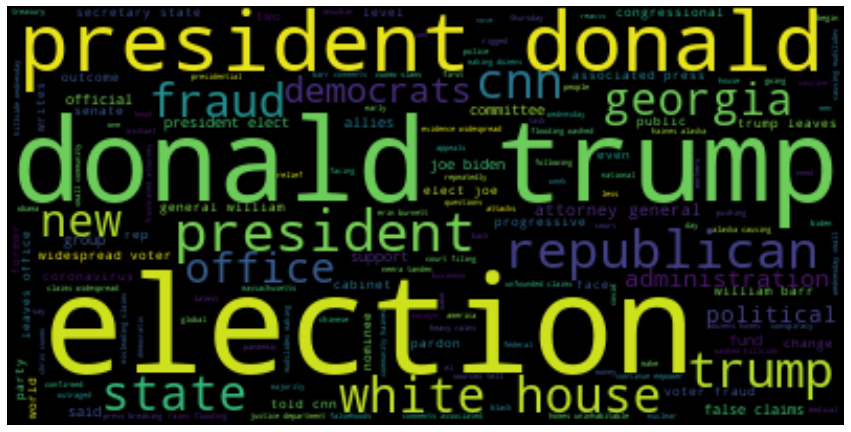

In [140]:
# creating the wordcloud object with some properties
wordcloud_spam = WordCloud(background_color="black").generate(all_corpus_text)

# plot the word cloud
plt.figure(figsize = (15,15))
plt.imshow(wordcloud_spam, interpolation='bilinear')
plt.axis("off")
plt.show()

In [47]:
import sklearn.feature_extraction.text as text
# defining the getNgrams method to create Unigram and bigrams
def getNgrams(data,ngrams,max_feature):

  # creaing CountVectorizer object with some entities
  tfidf = text.CountVectorizer(data,ngram_range=(ngrams,ngrams),max_features=max_feature,stop_words='english')

  # Transfering our data into ngarms
  grams = tfidf.fit_transform(data)

  # returning the ngram results as pandas Series
  return pd.Series(np.array(grams.sum(axis=0))[0],index = tfidf.get_feature_names()).sort_values(ascending=False).head(100)
  

In [48]:
# calling getNgrams for unigram with ngrams = 1
data_unigram = getNgrams(corpus_data,ngrams=1,max_feature=5000)

# calling getNgrams for bigram with ngrams = 2
data_bigram = getNgrams(corpus_data, ngrams= 2, max_feature=5000)


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text major ticklabel objects>)

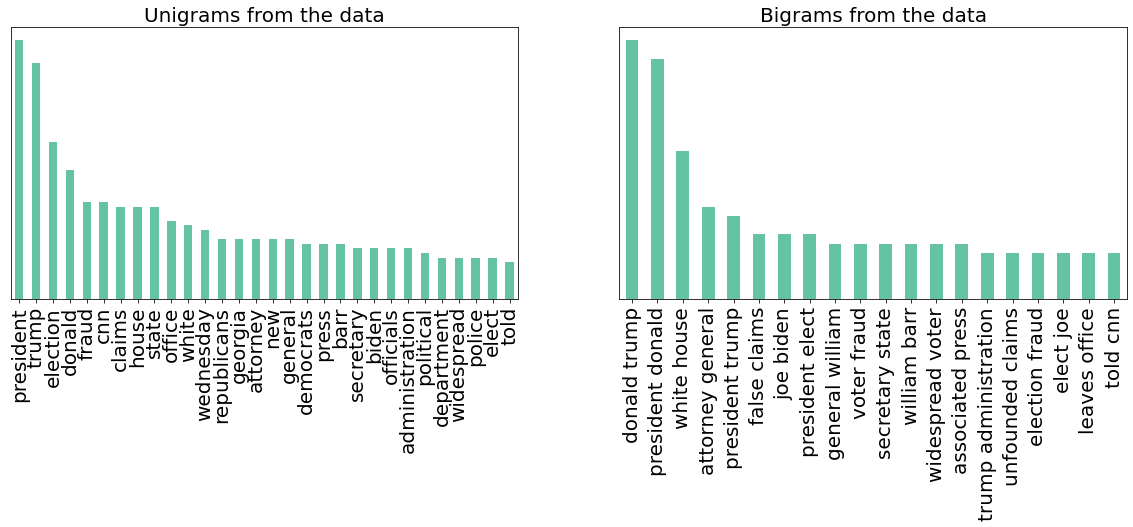

In [49]:
#ploting Unigram and Bigrams using matplotlib
plt.subplot(1,2,1)
data_unigram.head(30).plot(kind="bar",figsize=(20,5),colormap='Set2')
plt.title("Unigrams from the data",fontsize=20)
plt.yticks([])
plt.xticks(size=20)

plt.subplot(1,2,2)
data_bigram.head(20).plot(kind="bar",figsize=(20,5),colormap='Set2')
plt.title("Bigrams from the data",fontsize=20)
plt.yticks([])
plt.xticks(size=20)

Here we can see that the unigram used often is 'predident' and the bigram is 'donald trump' and 'president donalt' 
Try to extract the data which containe  these words and predict the sentiment of the people about this bigram and unigram words.

In [81]:
## extract the data contains  this token 'donalt trump'
d = pd.Series(data['description'])
index=d.str.match(r'(?=.*\bDonald Trump\b)|(?=.*\bPresident Donald\b).*$',case=False)
index=index.fillna(False)
donalt_trump_data=data.loc[index]



# Sentiment Analysis 
VADER (Valence Aware Dictionary and sEntiment Reasoner)

In [83]:
! pip3 install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 


     |████████████████████████████████| 133kB 5.8MB/s 


In [92]:
for index,text in enumerate(data['description']):
  if isinstance(text,float):
    data['description'][index] = str(data['description'][index])

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


In [93]:
#creating the object
sa = SentimentIntensityAnalyzer()

#iterate through the discribtion and find the polarity score
data_scored = data['description'].apply(sa.polarity_scores).to_list()

data_scored_df = pd.DataFrame(data_scored)

#join the scores to the exsisting data
data_scored_full = data.join(data_scored_df)
data_scored_full[:8]

,author,description,publishedAt,neg,neu,pos,compound
0,,"Gabriel Sterling, the voting systems implement...",03-12-2020,0.139,0.773,0.088,-0.4404
1,,President Trump and his allies are repeatedly ...,03-12-2020,0.195,0.664,0.141,-0.3818
2,Amir Vera and Andy Rose,Heavy rains and flooding washed out a hillside...,03-12-2020,0.000,1.000,0.000,0.0000
3,,"Gabriel Sterling, the voting systems implement...",03-12-2020,0.139,0.773,0.088,-0.4404
4,Jim Acosta and Devan Cole,President Donald Trump is frustrated with Atto...,03-12-2020,0.194,0.806,0.000,-0.8020
5,Amir Vera and Andy Rose,Heavy rains and flooding washed out a hillside...,03-12-2020,0.000,1.000,0.000,0.0000
6,Analysis by Zachary B. Wolf,There are not Republicans and Democrats this m...,03-12-2020,0.093,0.907,0.000,-0.5267
7,Jim Acosta and Devan Cole,President Donald Trump is frustrated with Atto...,03-12-2020,0.194,0.806,0.000,-0.8020


Text(0.5, 0, '')

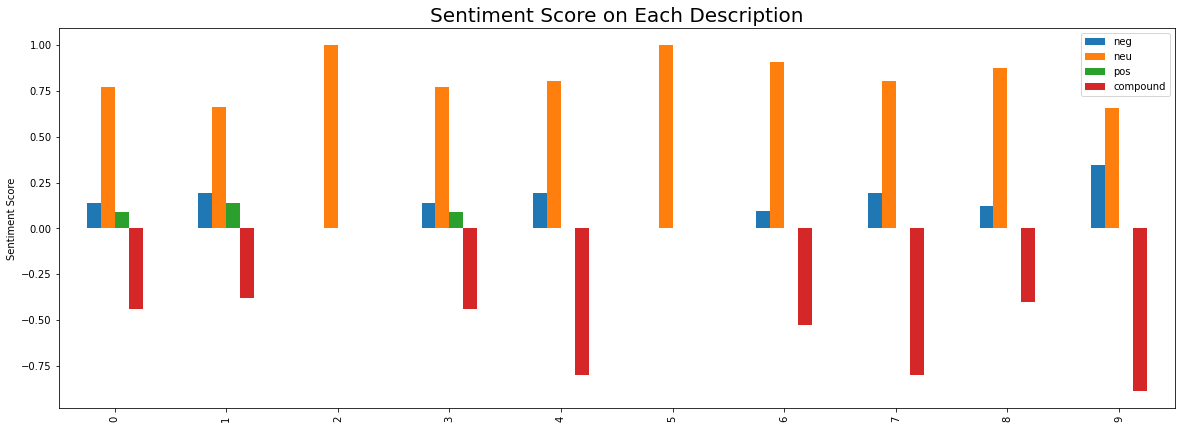

In [137]:
data_scored_full[:10].plot(kind='bar',figsize=(20,7))
plt.title("Sentiment Score on Each Description",fontsize=20)
plt.ylabel("Sentiment Score")
plt.xlabel("")

In [94]:
#creating the new column using the compount value in the data
conditions = [
              (data_scored_full['compound'] >= 0.5),
              (data_scored_full['compound'] > -0.5) & (data_scored_full['compound'] <= 0.5),
              (data_scored_full['compound'] <= -0.5)
]
values = ['Positive','Nutral','Negative']

data_scored_full['status'] = np.select(conditions,values)
data_scored_full[:10]

,author,description,publishedAt,neg,neu,pos,compound,status
0,,"Gabriel Sterling, the voting systems implement...",03-12-2020,0.139,0.773,0.088,-0.4404,Nutral
1,,President Trump and his allies are repeatedly ...,03-12-2020,0.195,0.664,0.141,-0.3818,Nutral
2,Amir Vera and Andy Rose,Heavy rains and flooding washed out a hillside...,03-12-2020,0.000,1.000,0.000,0.0000,Nutral
3,,"Gabriel Sterling, the voting systems implement...",03-12-2020,0.139,0.773,0.088,-0.4404,Nutral
4,Jim Acosta and Devan Cole,President Donald Trump is frustrated with Atto...,03-12-2020,0.194,0.806,0.000,-0.8020,Negative
5,Amir Vera and Andy Rose,Heavy rains and flooding washed out a hillside...,03-12-2020,0.000,1.000,0.000,0.0000,Nutral
6,Analysis by Zachary B. Wolf,There are not Republicans and Democrats this m...,03-12-2020,0.093,0.907,0.000,-0.5267,Negative
7,Jim Acosta and Devan Cole,President Donald Trump is frustrated with Atto...,03-12-2020,0.194,0.806,0.000,-0.8020,Negative
8,,CNN's Chris Cuomo slams Republicans who contin...,03-12-2020,0.124,0.876,0.000,-0.4019,Nutral
9,,"Amid false claims of fraud by President Trump,...",03-12-2020,0.344,0.656,0.000,-0.8885,Negative


([], <a list of 0 Text major ticklabel objects>)

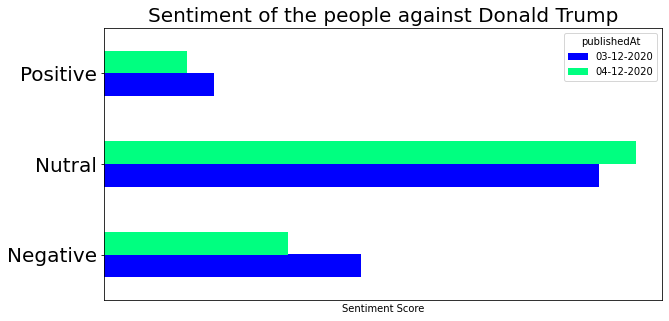

In [112]:
# ploting the bar chart
sum_score = data_scored_full.groupby(['status','publishedAt',]).count() 
sum_score = sum_score.unstack()


sum_score['compound'].plot(kind='barh',figsize=(10,5),colormap='winter')
plt.title("Sentiment of the people against Donald Trump",fontsize=20)
plt.xlabel("Sentiment Score")
plt.ylabel("")
plt.yticks(size=20)
plt.xticks([])



In [115]:
# Finding the Author name  who's article have high Nutral response among people
# Extracting the rows having Nurtal response

nutral_res = data_scored_full[data_scored_full['status'] == 'Nutral']
nutral_res.head()

,author,description,publishedAt,neg,neu,pos,compound,status
0,,"Gabriel Sterling, the voting systems implement...",03-12-2020,0.139,0.773,0.088,-0.4404,Nutral
1,,President Trump and his allies are repeatedly ...,03-12-2020,0.195,0.664,0.141,-0.3818,Nutral
2,Amir Vera and Andy Rose,Heavy rains and flooding washed out a hillside...,03-12-2020,0.000,1.000,0.000,0.0000,Nutral
3,,"Gabriel Sterling, the voting systems implement...",03-12-2020,0.139,0.773,0.088,-0.4404,Nutral
5,Amir Vera and Andy Rose,Heavy rains and flooding washed out a hillside...,03-12-2020,0.000,1.000,0.000,0.0000,Nutral


In [131]:
# Author name who's article having more Nutral review
nutral_res_count = nutral_res.groupby('author',as_index=False).count()
nutral_res_count =  nutral_res_count.sort_values(by=['status'])
nutral_res_count.iloc[0,0]

'Mallika Kallingal'